# Clone GitHub repository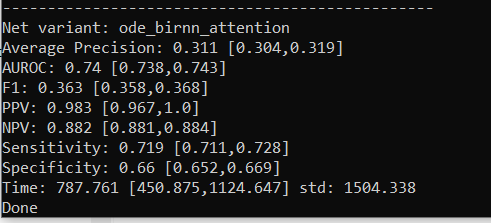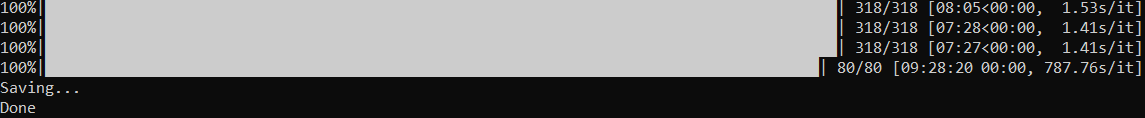

In [1]:
from google.colab import drive

import os

# Specify the directory path
repo_dir = '/content/CS598DL4H_Team_18'

# Check if the directory exists
if os.path.exists(repo_dir):
    # If it exists, navigate to the repository directory and pull changes
    %cd $repo_dir
    !git pull origin main
else:
    # If it doesn't exist, create it and clone the repository
    os.makedirs(repo_dir)
    %cd $repo_dir
    !git clone https://github.com/aprakash16/CS598DL4H_Team_18.git .
    !mkdir data

/content/CS598DL4H_Team_18
From https://github.com/aprakash16/CS598DL4H_Team_18
 * branch            main       -> FETCH_HEAD
Already up to date.


# Introduction

* <strong>Background</strong> <br>
The study is based on the paper Barbieri, S., Kemp, J., Perez-Concha, O. et al. “Benchmarking Deep Learning Architectures for Predicting Readmission to the ICU and Describing Patients-at-Risk”, Sci Rep 10, 1111 (2020) https://doi.org/10.1038/s41598-020-58053-z. The original authors have provided the code <a href="https://github.com/sebbarb/time_aware_attention/tree/master">here</a>. We will use the existing code of the original authors so that, there are minimum side effects. Our plan includes to add two ablations mentioned in *Scope of Reproducibility* section.
<br>In the realm of healthcare, predicting readmission to the Intensive Care Unit (ICU) plays a crucial role in improving patient outcomes and optimizing resource allocation. This problem falls under the domain of disease readmission prediction, a critical area in healthcare analytics. The ability to accurately forecast which patients are at risk of being readmitted to the ICU within a certain timeframe is essential for healthcare providers to intervene early and provide appropriate care, ultimately reducing healthcare costs and improving patient care quality.

* <strong>Importance:</strong> <br>
Solving the challenge of predicting ICU readmissions holds significant importance in healthcare systems worldwide. ICU readmissions not only impact patient health but also contribute to avoidable costs within the healthcare system. By accurately identifying patients at risk of readmission, healthcare providers can implement preventive measures, allocate resources efficiently, and enhance patient care strategies. However, the complexity of the problem lies in the dynamic nature of patient health data, the need for feature engineering from diverse sources, and the requirement for interpretable models to guide clinical decision-making.

* <strong>State of the Art </strong><br>
Current state-of-the-art methods for predicting ICU readmissions often rely on traditional scoring systems like APACHE, SAPS, and OASIS, which have shown moderate predictive power. However, the application of novel machine learning algorithms to electronic medical record (EMR) data has the potential to enhance prediction accuracy and provide more personalized insights into patient outcomes. Deep learning architectures, attention mechanisms, recurrent neural networks, and Bayesian inference have emerged as promising tools for tackling the challenges of ICU readmission prediction.

* <strong>Paper Explanation</strong><br>
The paper proposes a comprehensive comparison of deep learning architectures for predicting ICU readmissions within 30 days of discharge, leveraging attention-based models for interpretability. The innovation lies in the application of neural ordinary differential equations (ODEs) to model the evolving relevance of medical codes over time, providing a dynamic perspective on patient health trajectories. The proposed method demonstrates competitive predictive accuracy across various neural network architectures, with attention-based models offering interpretability at a marginal cost in accuracy.

* <strong>Contribution</strong><br>
This paper's contribution to the research regime is significant as it not only benchmarks deep learning models for ICU readmission prediction but also emphasizes the importance of interpretable models in healthcare analytics. By showcasing the effectiveness of attention-based networks and Bayesian inference in predicting ICU readmissions, the study paves the way for more accurate and transparent predictive models in clinical settings, thereby enhancing patient care and healthcare system efficiency.

* <strong>Public repository link (Github)</strong> <br>
The .ipynb file along with the supplementary code can be found in <a href = "https://github.com/aprakash16/CS598DL4H_Team_18">Github repository</a>. This repository will not contain the original MIMIC-III datasets (raw data) due to license and privacy restrictions. However, you can download and place the data when you clone the repository based on the steps given Methodology - Data section. <br>
If you wish to reproduce this in the local isolated environment u=you can you this <a href="https://github.com/aprakash16/CS598DL4H_Team_18/blob/main/Dockerfile">Dockerfile</a>.
* **Please note:** The same supplementary code which is uploaded in Github has also been placed in google drive for demonstration purpose only. Hence, a subset of the data has been placed in Google drive. The reason for using Google drive is some files (eg. data_arrays.npz - 426MB) are very large and hence cannot be uploaded on Github (max file size limit is 25 MB). PhysioNet has provided public access to MIMIC-III demo data (https://physionet.org/content/mimiciii-demo/1.4/) which has open-access and we will be using for demonstration here. However, the original work has been done on the local setup with the full version of the MIMIC-III dataset.

# Scope of Reproducibility

The following hypotheses will be tested:

1. Hypothesis 1: Recurrent models outperform models that only use attention layers by a small margin.
2. Hypothesis 2: Adding attention layers to deep neural networks may improve the model's interpretability but does not degrade average precision.


Following ablations have been planned as well in order to observe the impact of eliminating timestamped code from model's embeddings:

1. RNN: Embeddings are passed into RNN layers directly.
2. RNN + Attention: Embeddings are provided to RNN layers, followed by the application of attention to the RNN outputs

**Please note:** This paper compared the performance of 14 models. These are computationally intensive and require significant resources for training and inference. Two ablations will be added as well. This is very time consuming. Also, due to resource limitation, it is be extremely difficult to run all the models. Hence, one model will be chosen to reproduce:
1. ODE + RNN + Attention: As per the paper, this model had the highest performance in terms of accuracy as compared to the other deep learning architectures.



# Methodology


In [2]:
# import  packages
import numpy as np
import torch

In [3]:
try:
    import torchdiffeq
except ImportError:
    print("torchdiffeq is not installed. Installing...")
    !pip install torchdiffeq
    import torchdiffeq

##  Data

  * <strong>Source of the data:</strong> <a href="https://physionet.org/content/mimiciii/1.4/">MIMIC-III Clinical Database 1.4</a> data will be used. It is available on <a href="https://physionet.org/">PhysioNet</a>. For accessing the data, a request needs to be raised. Once the data is available, place the datasets in "mimic-iii-clinical-database-1.4" folder at the root of the repository. Please note, you will need to unzip those files as most of them would be downloaded in .gz file format. Due to health data license and privacy concern, this dataset has not been directly placed in the public repository.

  * <strong>Dataset details:</strong> The dataset includes patient health data with 61,532 ICU stays as well as 46,476 critical care stays, between year 2001 and 2012. The database contains 26 tables. They are linked by identifiers with suffix'_ID'.
  * <strong>Data process:</strong>
    - Patients who died during the ICU stay, were not adults (18 years or older) at the time of discharge, or died within 30 days from discharge without being readmitted to the ICU were excluded from the analysis. This step involved filtering out these cases from the dataset to focus on the target population.
    - The final dataset comprised ICU stays labeled as either positive (indicating readmission within 30 days) or negative (indicating no readmission within 30 days). This class labeling allowed for the classification task of predicting ICU readmissions.
    - The patients were randomly subdivided into training and validation sets (90%) and a separate test set (10%). This splitting was based on patient identifiers to prevent information leaks between the datasets and ensure the models were evaluated on unseen data.
    - The dataset underwent further refinement steps, such as handling missing values, encoding categorical variables, normalizing numerical features, and balancing the class distribution if necessary. These steps are common in data preprocessing to ensure the data is suitable for training machine learning models.
    - Feature engineering was performed to extract relevant information from the EMR data, and transform existing features to improve the predictive performance of the models. This step involved deriving additional variables and aggregating information from different sources within the EMR data.
  * <strong>Step for pre-processing data:</strong> We will refer to the code provided by the authors. Please refer to https://github.com/aprakash16/CS598DL4H_Team_18/tree/main/related_code. Each data pre-processing script took approximately 7 minutes 26 seconds to run (total time = ). Hence, due to time-constraint, the pre-processing scripts have been executed offline. The pre-processed data has not been provided in the repository as it will violate the data privacy policies and HIPAA regulations.
The following data pre-processing scripts can be found in 'related_code' folder in Github repository:
1. 1_preprocessing_ICU_PAT_ADMIT.py
2. 2_preprocessing_reduce_charts.py
3. 3_preprocessing_reduce_outputs.py
4. 4_preprocessing_merge_charts_outputs.py
5. 5_preprocessing_CHARTS_PRESCRIPTIONS.py
6. 6_preprocessing_DIAGNOSES_PROCEDURES.py
7. 7_preprocessing_create_arrays.py

Once, you have placed the unzipped the MIMIC-III datasets and placed them in "mimic-iii-clinical-database-1.4", open shell in the root folder and execute the following commands for pre-processing the data.

**Please note:** The following snippet is only for the demonstration purpose and the subset of the MIMIC-III dataset (open-access provided by PhysioNet for demo purposes) has been used. The training has been done originally on the full version of the MIMIC-III dataset.





In [4]:
#The original author's code is compatible with pandas 1.3.3 version. It does not work with higher versions
import pandas as pd

desired_version = '1.3.3'

if pd.__version__ != desired_version:
    print(f"Detected Pandas version: {pd.__version__}. Uninstalling...")
    !pip uninstall pandas -y
    print(f"Installing Pandas version: {desired_version}...")
    !pip install pandas=={desired_version}
else:
    print(f"Pandas version {desired_version} is already installed.")


Pandas version 1.3.3 is already installed.


In [5]:
#The following code has been commented as it is not required to be executed in this notebook. Please uncomment before executing the commands.
#The pre-processed data has been trained offline and the trained model checkpoints are available to load and evaluate in the github repository.

!python3 related_code/1_preprocessing_ICU_PAT_ADMIT.py
!python3 related_code/2_preprocessing_reduce_charts.py
!python3 related_code/3_preprocessing_reduce_outputs.py
!python3 related_code/4_preprocessing_merge_charts_outputs.py
!python3 related_code/5_preprocessing_CHARTS_PRESCRIPTIONS.py
!python3 related_code/6_preprocessing_DIAGNOSES_PROCEDURES.py
!python3 related_code/7_preprocessing_create_arrays.py

Load ICU stays...
-----------------------------------------
Load patients...
-----------------------------------------
Load admissions...
-----------------------------------------
Load services...
-----------------------------------------
Link icustays and patients tables...
Compute number of recent admissions...
100% 77/77 [00:00<00:00, 481.11it/s]
-----------------------------------------
Link icu_pat and admissions tables...
SUBJECT_ID               0
HADM_ID                  0
ICUSTAY_ID               0
INTIME                   0
OUTTIME                  0
LOS                      0
GENDER_M                 0
NUM_RECENT_ADMISSIONS    0
AGE                      0
POSITIVE                 0
ADMITTIME                0
ADMISSION_TYPE           0
ADMISSION_LOCATION       0
INSURANCE                0
MARITAL_STATUS           5
ETHNICITY                0
dtype: int64
Some data cleaning on admissions...
-----------------------------------------
Link services table...
----------------------

##   Model
* **ODE+RNN+Attention:** Use neural ODEs to model dynamics in time of embeddings, embeddings are then passed to RNN layers, with attention applied to the RNN outputs.<br>
  - ODE Layer: The ODE layer captures the temporal dynamics of the system. This could be represented by the differential equations governing the evolution of the system over time. The model uses techniques such as Neural ODEs (Ordinary Differential Equations) to parameterize the dynamics.<br>
  - RNN Layer: The RNN layer processes the sequential data and captures temporal dependencies. In the paper, an LSTM (Long Short-Term Memory) network is used, which is a type of recurrent neural network known for its ability to retain information over long sequences.<br>
  - Attention Mechanism: The attention mechanism focuses on relevant parts of the input sequence at each time step. It attends to different time points in the input sequence based on their relevance to the prediction at the current time step.<br>

  The following code has been provided for demonstration purpose. The code is available https://github.com/aprakash16/CS598DL4H_Team_18/blob/main/related_code/modules.py.

In [6]:
# #Code snippet of the model
# # Attention Only
#   class Net(nn.Module):
#     def __init__(self, num_static, num_dp_codes, num_cp_codes):
#       super(Net, self).__init__()

#       # Embedding dimensions
#       self.embed_dp_dim = int(np.ceil(num_dp_codes**0.25))+1
#       self.embed_cp_dim = int(np.ceil(num_cp_codes**0.25))+1

#       # Embedding layers
#       self.embed_dp = nn.Embedding(num_embeddings=num_dp_codes, embedding_dim=self.embed_dp_dim, padding_idx=0)
#       self.embed_cp = nn.Embedding(num_embeddings=num_cp_codes, embedding_dim=self.embed_cp_dim, padding_idx=0)

#       # ODE layers
#       self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#       self.ode_dp = ODENet(self.device, self.embed_dp_dim, self.embed_dp_dim, output_dim=self.embed_dp_dim, augment_dim=0, time_dependent=False, non_linearity='softplus', tol=1e-3, adjoint=True)
#       self.ode_cp = ODENet(self.device, self.embed_cp_dim, self.embed_cp_dim, output_dim=self.embed_cp_dim, augment_dim=0, time_dependent=False, non_linearity='softplus', tol=1e-3, adjoint=True)

#       # GRU layers
#       self.gru_dp_fw = nn.GRU(input_size=self.embed_dp_dim, hidden_size=self.embed_dp_dim, num_layers=1, batch_first=True)
#       self.gru_cp_fw = nn.GRU(input_size=self.embed_cp_dim, hidden_size=self.embed_cp_dim, num_layers=1, batch_first=True)
#       self.gru_dp_bw = nn.GRU(input_size=self.embed_dp_dim, hidden_size=self.embed_dp_dim, num_layers=1, batch_first=True)
#       self.gru_cp_bw = nn.GRU(input_size=self.embed_cp_dim, hidden_size=self.embed_cp_dim, num_layers=1, batch_first=True)

#       # Attention layers
#       self.attention_dp = Attention(embedding_dim=2*self.embed_dp_dim)
#       self.attention_cp = Attention(embedding_dim=2*self.embed_cp_dim)

#       # Fully connected output
#       self.fc_dp  = nn.Linear(2*self.embed_dp_dim, 1)
#       self.fc_cp  = nn.Linear(2*self.embed_cp_dim, 1)
#       self.fc_all = nn.Linear(num_static + 2, 1)

#       # Others
#       self.dropout = nn.Dropout(p=0.5)

#     def forward(self, stat, dp, cp, dp_t, cp_t):
#       # Embedding
#       ## output dim: batch_size x seq_len x embedding_dim
#       embedded_dp = self.embed_dp(dp)
#       embedded_cp = self.embed_cp(cp)

#       # ODE
#       ## Round times
#       dp_t = torch.round(100*dp_t)/100
#       cp_t = torch.round(100*cp_t)/100

#       embedded_dp_long = embedded_dp.view(-1, self.embed_dp_dim)
#       dp_t_long = dp_t.view(-1)
#       dp_t_long_unique, inverse_indices = torch.unique(dp_t_long, sorted=True, return_inverse=True)
#       ode_dp_long = self.ode_dp(embedded_dp_long, dp_t_long_unique)
#       ode_dp_long = ode_dp_long[inverse_indices, torch.arange(0, inverse_indices.size(0)), :]
#       ode_dp = ode_dp_long.view(dp.size(0), dp.size(1), self.embed_dp_dim)

#       embedded_cp_long = embedded_cp.view(-1, self.embed_cp_dim)
#       cp_t_long = cp_t.view(-1)
#       cp_t_long_unique, inverse_indices = torch.unique(cp_t_long, sorted=True, return_inverse=True)
#       ode_cp_long = self.ode_cp(embedded_cp_long, cp_t_long_unique)
#       ode_cp_long = ode_cp_long[inverse_indices, torch.arange(0, inverse_indices.size(0)), :]
#       ode_cp = ode_cp_long.view(cp.size(0), cp.size(1), self.embed_cp_dim)

#       ## Dropout
#       ode_dp = self.dropout(ode_dp)
#       ode_cp = self.dropout(ode_cp)

#       # Forward and backward sequences
#       ## output dim: batch_size x seq_len x embedding_dim
#       ode_dp_fw = ode_dp
#       ode_cp_fw = ode_cp
#       ode_dp_bw = torch.flip(ode_dp_fw, [1])
#       ode_cp_bw = torch.flip(ode_cp_fw, [1])

#       # GRU
#       ## output dim rnn:        batch_size x seq_len x embedding_dim
#       ## output dim rnn_hidden: batch_size x 1 x embedding_dim
#       rnn_dp_fw, rnn_hidden_dp_fw = self.gru_dp_fw(ode_dp_fw)
#       rnn_cp_fw, rnn_hidden_cp_fw = self.gru_cp_fw(ode_cp_fw)
#       rnn_dp_bw, rnn_hidden_dp_bw = self.gru_dp_bw(ode_dp_bw)
#       rnn_cp_bw, rnn_hidden_cp_bw = self.gru_cp_bw(ode_cp_bw)
#       # concatenate forward and backward
#       ## output dim: batch_size x seq_len x 2*embedding_dim
#       rnn_dp = torch.cat((rnn_dp_fw, torch.flip(rnn_dp_bw, [1])), dim=-1)
#       rnn_cp = torch.cat((rnn_cp_fw, torch.flip(rnn_cp_bw, [1])), dim=-1)

#       # Attention
#       ## output dim: batch_size x 2*embedding_dim
#       attended_dp, weights_dp = self.attention_dp(rnn_dp, (dp > 0).float())
#       attended_cp, weights_cp = self.attention_cp(rnn_cp, (cp > 0).float())

#       # Scores
#       score_dp = self.fc_dp(self.dropout(attended_dp))
#       score_cp = self.fc_cp(self.dropout(attended_cp))

#       # Concatenate to variable collection
#       all = torch.cat((stat, score_dp, score_cp), dim=1)

#       # Final linear projection
#       out = self.fc_all(self.dropout(all)).squeeze()

#       return out, []

##   Training

**Training model:** Training ODE+RNN+Attention model took 9 hrs 28 minutes on local machine. Hence, due to time constraint, the model was trained in local setup and the trained model checkpoint has been uploaded in https://github.com/aprakash16/CS598DL4H_Team_18/blob/main/logdir-final/ode_birnn_attention. Please refer to 'final_model.pt' file.

**Computational requirements:** Our attempt was to work with Google Colab as it offers runtime types like CPU and GPU but GPU resources are limited in free account. Also, the size of dataset was very large. Hence, we used HP Pavilion Intel(R) Core(TM) i7-10870H CPU @ 2.20GHz with 16GB RAM.

We will use the code provided by the original authors. Please refer to https://github.com/aprakash16/CS598DL4H_Team_18/blob/main/related_code/train.py for the training model code. To train the model, the following code has been used. As it takes approximately 9.5 hrs to train, we have uploaded the trained model checkpoint in the github repository.

For training (full version of MIMIC-III dataset) on local setup:
* batch size: 128
* number of epochs: 80
* dropout rate: 0.5
* patience (early stopping): 10
* runtime for each epoch: 07:01 - 08:05 minutes
* total time to train model: 09:28:20 hrs

**Please note:** For the sake of demonstrating runnable training code, we have taken a subset of the MIMIC-III data which is publicly accessible and have run the training script for it.
The final trained model that we are using in *Methodology.Evaluation* section is being done on the full version of the dataset.

In [7]:
!bash /content/CS598DL4H_Team_18/train_model.sh

1) ODE + RNN + Attention
2) QUIT
Which model do you want to train? 1
Training ODE + RNN + Attention (ode_birnn_attention) ...
Load data...
-----------------------------------------
Train...
  0% 0/80 [00:00<?, ?it/s]
0it [00:00, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
0it [00:00, ?it/s]

0it [00:00, ?it/s]
  2% 2/80 [00:00<00:04, 18.22it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
  6% 5/80 [00:00<00:03, 20.63it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
 10% 8/80 [00:00<00:03, 20.74it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
 14% 11/80 [00:00<00:03, 20.00it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
 16% 13/80 [00:00<00:03, 19.30it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
 20% 16/80 [00:00<00:03, 19.92it/s]
0it [0

In [8]:
#run this to download the final trained model from Google drive.

#The same supplementary code which is uploaded in Github has also been placed in google drive for demonstration purpose only.
#Hence, a subset of the data has been placed in Google drive. The reason for using Google drive is some files (eg. data_arrays.npz - 426MB)
#are very large and hence cannot be uploaded on Github (max file size limit is 25 MB).
try:
    import gdown
except ImportError:
    print("gdown is not installed. Installing...")
    !pip install gdown
    import gdown

import shutil
# Define the URL of the public folder
url = "https://drive.google.com/drive/folders/1JHb6mHWo97uug4x0E5N04-2KX6erA4dB"

# Define the path where you want to download the folder
output_folder = "/content/CS598-DL4H-Team18-final"

# Remove the existing folder if it exists
shutil.rmtree(output_folder, ignore_errors=True)

# Download the folder contents
gdown.download_folder(url, output=output_folder, quiet=False)


Retrieving folder contents


Retrieving folder 1FVk__ACdubaHz0_gMugOkXqwLXQ-eUYy data
Processing file 19fs8nuUI0ZHWoVQRrs3L6h5cBT2SFTOv data_arrays.npz
Processing file 1qcrNWb1GdBX8jct_qZaLBIkgVR3MdIz7 test_ids_patients.pkl
Processing file 1kIXfybocTDIhxRsXfshISOyVHrUjMmPF Dockerfile
Processing file 1ZtodqJxf2eb8aJsENZEwgg2PtPvr23wi eval_model.sh
Retrieving folder 15PP0RBNoWXwyl5fkA0GiOLHG4YjMflLN logdir
Retrieving folder 1yeQab3xiwUpqy5nBsdkibCW6L9vvF3ta ode_birnn_attention
Processing file 1pRvui7NzpRqiJnP2sx2ued0SueM0cS3i epoch_times.npz
Processing file 1pruZTvX5h-jvHBJb8jZzEb-HCCXCLYJH final_model.pt
Retrieving folder 12-mvgUxT4JlLzoZR_ak9X1ezYnNNTKEh mimic-iii-clinical-database-1.4
Processing file 1dqumtKiLMBR2444NuI2wx650HRS3IHON ADMISSIONS.csv
Processing file 1sqOu39urse4dqRLJdfg7Nwfh9XQYe3_U CALLOUT.csv
Processing file 1dI3tHD_LcfdDi0xxVWzK2koBkMMvM-qP CAREGIVERS.csv
Processing file 1wHQAiBfRw4w0hi_8O8mEGis-ApV0o63B CHARTEVENTS.csv
Processing file 1eETouFkHzGO3c1cKn3Z_MNUVSVe8fYIz D_ITEMS.csv
Processing fil

Retrieving folder contents completed
Building directory structure
Downloading...
From (original): https://drive.google.com/uc?id=19fs8nuUI0ZHWoVQRrs3L6h5cBT2SFTOv
From (redirected): https://drive.google.com/uc?id=19fs8nuUI0ZHWoVQRrs3L6h5cBT2SFTOv&confirm=t&uuid=6840ce05-90c6-47b5-aa67-dc6d3a7335e1
To: /content/CS598-DL4H-Team18-final/data/data_arrays.npz
100%|██████████| 436M/436M [00:02<00:00, 170MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qcrNWb1GdBX8jct_qZaLBIkgVR3MdIz7
To: /content/CS598-DL4H-Team18-final/data/test_ids_patients.pkl
100%|██████████| 18.9k/18.9k [00:00<00:00, 27.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kIXfybocTDIhxRsXfshISOyVHrUjMmPF
To: /content/CS598-DL4H-Team18-final/Dockerfile
100%|██████████| 219/219 [00:00<00:00, 524kB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1ZtodqJxf2eb8aJsENZEwgg2PtPvr23wi
From (redirected): https://drive.google.com/uc?id=1ZtodqJxf2eb8aJsENZEwgg2PtPvr23wi&confirm=t&uuid=d4fd867f-fe0

['/content/CS598-DL4H-Team18-final/data/data_arrays.npz',
 '/content/CS598-DL4H-Team18-final/data/test_ids_patients.pkl',
 '/content/CS598-DL4H-Team18-final/Dockerfile',
 '/content/CS598-DL4H-Team18-final/eval_model.sh',
 '/content/CS598-DL4H-Team18-final/logdir/ode_birnn_attention/epoch_times.npz',
 '/content/CS598-DL4H-Team18-final/logdir/ode_birnn_attention/final_model.pt',
 '/content/CS598-DL4H-Team18-final/mimic-iii-clinical-database-1.4/ADMISSIONS.csv',
 '/content/CS598-DL4H-Team18-final/mimic-iii-clinical-database-1.4/CALLOUT.csv',
 '/content/CS598-DL4H-Team18-final/mimic-iii-clinical-database-1.4/CAREGIVERS.csv',
 '/content/CS598-DL4H-Team18-final/mimic-iii-clinical-database-1.4/CHARTEVENTS.csv',
 '/content/CS598-DL4H-Team18-final/mimic-iii-clinical-database-1.4/D_ITEMS.csv',
 '/content/CS598-DL4H-Team18-final/mimic-iii-clinical-database-1.4/DIAGNOSES_ICD.csv',
 '/content/CS598-DL4H-Team18-final/mimic-iii-clinical-database-1.4/ICUSTAYS.csv',
 '/content/CS598-DL4H-Team18-final/m

Load the trained model (done on full version of MIMIC-III dataset on local environment) by executing the following:

In [9]:
%cd /content/CS598-DL4H-Team18-final
# Load the model from the .pt file
model = torch.load('/content/CS598-DL4H-Team18-final/logdir/ode_birnn_attention/final_model.pt')

/content/CS598-DL4H-Team18-final


The shell script (training.sh) calls a helper function which call the below method for training. This is a code snippet of the training model that we are running:

In [10]:
# #If there is any issue related to libraries installed, please uncomment the following command and execute it:
# #!pip install -r /content/CS598DL4H_Team_18/related_code/requirements.txt

# # Code snippet for training:

# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# import numpy as np
# from hyperparameters import Hyperparameters as hp
# from data_load import *
# from modules import *
# import os
# from tqdm import tqdm
# from time import time
# from sklearn.metrics import accuracy_score, confusion_matrix, average_precision_score, roc_auc_score, f1_score
# from pdb import set_trace as bp


# def main():
#   # Load data
#   print('Load data...')
#   data = np.load(hp.data_dir + 'data_arrays.npz', allow_pickle=True)

#   # Training and validation data
#   if hp.all_train:
#     trainloader, num_batches, pos_weight = get_trainloader(data, 'ALL')
#   else:
#     trainloader, num_batches, pos_weight = get_trainloader(data, 'TRAIN')

#   # Vocabulary sizes
#   num_static = num_static_data(data)
#   num_dp_codes, num_cp_codes = vocab_sizes(data)

#   print('-----------------------------------------')
#   print('Train...')

#   # CUDA for PyTorch
#   use_cuda = torch.cuda.is_available()
#   device = torch.device('cuda:0' if use_cuda else 'cpu')
#   torch.backends.cudnn.benchmark = True

#   # Network
#   net = Net(num_static, num_dp_codes, num_cp_codes).to(device)

#   # Loss function and optimizer
#   criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
#   optimizer = optim.Adam(net.parameters(), lr = 0.001)

#   # Create log dir
#   logdir = hp.logdir + hp.net_variant + '/'
#   if not os.path.exists(logdir):
#     os.makedirs(logdir)

#   # Store times
#   epoch_times = []

#   # Train
#   for epoch in tqdm(range(hp.num_epochs)):
#     # print('-----------------------------------------')
#     # print('Epoch: {}'.format(epoch))
#     net.train()
#     time_start = time()
#     for i, (stat, dp, cp, dp_t, cp_t, label) in enumerate(tqdm(trainloader), 0):
#       # move to GPU if available
#       stat  = stat.to(device)
#       dp    = dp.to(device)
#       cp    = cp.to(device)
#       dp_t  = dp_t.to(device)
#       cp_t  = cp_t.to(device)
#       label = label.to(device)

#       # zero the parameter gradients
#       optimizer.zero_grad()

#       # forward + backward + optimize
#       label_pred, _ = net(stat, dp, cp, dp_t, cp_t)
#       loss = criterion(label_pred, label)
#       loss.backward()
#       optimizer.step()

#     # timing
#     time_end = time()
#     epoch_times.append(time_end-time_start)

#   # Save
#   print('Saving...')
#   torch.save(net.state_dict(), logdir + 'final_model.pt')
#   np.savez(logdir + 'epoch_times', epoch_times=epoch_times)
#   print('Done')

# if __name__ == '__main__':
#   main()

## Evaluation

We will run only 5 iterations in this notebook for demonstration. For reproducing the original paper, we have run 100 samples on our local setup.

These are performance metrics used to evaluate the ODE + RNN + Attention model described in the paper. Here's what each of these metrics represents:

* **Average Precision:** Average Precision is a metric used to evaluate the quality of binary classification models. It computes the area under the precision-recall curve, which represents the trade-off between precision and recall. Higher values indicate better performance.

* **AUROC (Area Under the Receiver Operating Characteristic Curve):** AUROC is another metric used to evaluate binary classification models. It measures the ability of the model to distinguish between positive and negative classes across different threshold values. Higher values indicate better discrimination performance.

* **F1 Score:** F1 Score is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall, making it useful for imbalanced datasets or when there is an uneven cost associated with false positives and false negatives.

* **PPV (Positive Predictive Value):** PPV, also known as precision, measures the proportion of true positive predictions out of all positive predictions made by the model. It represents the model's ability to correctly identify positive instances.

* **NPV (Negative Predictive Value):** NPV measures the proportion of true negative predictions out of all negative predictions made by the model. It represents the model's ability to correctly identify negative instances.

* **Sensitivity (True Positive Rate):** Sensitivity, also known as recall or true positive rate, measures the proportion of true positive predictions out of all actual positive instances. It represents the model's ability to correctly identify positive instances among all positive instances in the dataset.

* **Specificity (True Negative Rate):** Specificity measures the proportion of true negative predictions out of all actual negative instances. It represents the model's ability to correctly identify negative instances among all negative instances in the dataset.

* **Time:** Time represents the runtime of the model, typically measured in seconds. The values provided (mean and range) indicate the average runtime and its variability across different runs or experiments.

**Please note:** The evaluation here is being done on the trained model which was trained using the full version of the MIMIC-III dataset in order to show the actual results. Hence, as the dataset is extremely large it would take some time.

In [11]:
#Type 1 in the input field. Ablations are in progress.
!bash /content/CS598-DL4H-Team18-final/eval_model.sh

1) ODE + RNN + Attention       3) *ABLATION* RNN
2) *ABLATION* RNN + Attention  4) QUIT
Which model do you want to evaluate? 1
Evaluating ODE + RNN + Attention (ode_birnn_attention) ...
Load data...
Bootstrap sample 0
  0% 0/35 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Euler: Unexpected arguments {'max_num_steps': 1000}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
100% 35/35 [00:33<00:00,  1.06it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division

We will use the code provided by the original authors for test and validation. Please refer to https://github.com/aprakash16/CS598DL4H_Team_18/blob/main/related_code/test.py for the *test.py* code.

The shell script (eval.sh) calls a helper function which call the below method for evaluation. This is a code snippet of the test.py that we are running:

In [12]:
# from __future__ import print_function
# import torch
# import numpy as np
# import pandas as pd
# import pickle
# import scipy.stats as st
# from hyperparameters import Hyperparameters as hp
# from data_load import *
# from modules import *
# import os
# from tqdm import tqdm
# from train import Net
# #import matplotlib.pyplot as plt
# from sklearn.metrics import *
# from sklearn.calibration import calibration_curve
# from pdb import set_trace as bp

# def round(num):
#   return np.round(num*1000)/1000

# def main():
#   # Load data
#   print('Load data...')
#   data = np.load(hp.data_dir + 'data_arrays.npz')
#   test_ids_patients = pd.read_pickle(hp.data_dir + 'test_ids_patients.pkl')

#   # Patients in test data
#   patients = test_ids_patients.drop_duplicates()
#   num_patients = patients.shape[0]
#   row_ids = pd.DataFrame({'ROW_IDX': test_ids_patients.index}, index=test_ids_patients)

#   # Vocabulary sizes
#   num_static = num_static_data(data)
#   num_dp_codes, num_cp_codes = vocab_sizes(data)

#   # CUDA for PyTorch
#   use_cuda = torch.cuda.is_available()
#   device = torch.device('cuda:0' if use_cuda else 'cpu')
#   torch.backends.cudnn.benchmark = True

#   # Network
#   net = Net(num_static, num_dp_codes, num_cp_codes).to(device)

#   # Set log dir to read trained model from
#   logdir = hp.logdir + hp.net_variant + '/'

#   # Restore variables from disk
#   net.load_state_dict(torch.load(logdir + 'final_model.pt', map_location=device))

#   # Bootstrapping
#   np.random.seed(hp.np_seed)
#   avpre_vec = np.zeros(hp.bootstrap_samples)
#   auroc_vec = np.zeros(hp.bootstrap_samples)
#   f1_vec    = np.zeros(hp.bootstrap_samples)
#   sensitivity_vec = np.zeros(hp.bootstrap_samples)
#   specificity_vec = np.zeros(hp.bootstrap_samples)
#   ppv_vec = np.zeros(hp.bootstrap_samples)
#   npv_vec = np.zeros(hp.bootstrap_samples)

#   for sample in range(hp.bootstrap_samples):
#     print('Bootstrap sample {}'.format(sample))

#     # Test data
#     sample_patients = patients.sample(n=num_patients, replace=True)
#     idx = np.squeeze(row_ids.loc[sample_patients].values)
#     testloader, _, _ = get_trainloader(data, 'TEST', shuffle=False, idx=idx)

#     # evaluate on test data
#     net.eval()
#     label_pred = torch.Tensor([])
#     label_test = torch.Tensor([])
#     with torch.no_grad():
#       for i, (stat, dp, cp, dp_t, cp_t, label_batch) in enumerate(tqdm(testloader), 0):
#         # move to GPU if available
#         stat  = stat.to(device)
#         dp    = dp.to(device)
#         cp    = cp.to(device)
#         dp_t  = dp_t.to(device)
#         cp_t  = cp_t.to(device)

#         label_pred_batch, _ = net(stat, dp, cp, dp_t, cp_t)
#         label_pred = torch.cat((label_pred, label_pred_batch.cpu()))
#         label_test = torch.cat((label_test, label_batch))

#     label_sigmoids = torch.sigmoid(label_pred).cpu().numpy()

#     # Average precision
#     avpre = average_precision_score(label_test, label_sigmoids)

#     # Determine AUROC score
#     auroc = roc_auc_score(label_test, label_sigmoids)

#     # Sensitivity, specificity
#     fpr, tpr, thresholds = roc_curve(label_test, label_sigmoids)
#     youden_idx = np.argmax(tpr - fpr)
#     sensitivity = tpr[youden_idx]
#     specificity = 1-fpr[youden_idx]

#     # F1, PPV, NPV score
#     f1 = 0
#     ppv = 0
#     npv = 0
#     for t in thresholds:
#       label_pred = (np.array(label_sigmoids) >= t).astype(int)
#       f1_temp = f1_score(label_test, label_pred)
#       ppv_temp = precision_score(label_test, label_pred, pos_label=1)
#       npv_temp = precision_score(label_test, label_pred, pos_label=0)
#       if f1_temp > f1:
#         f1 = f1_temp
#       if (ppv_temp+npv_temp) > (ppv+npv):
#         ppv = ppv_temp
#         npv = npv_temp

#     # Store in vectors
#     avpre_vec[sample] = avpre
#     auroc_vec[sample] = auroc
#     f1_vec[sample]    = f1
#     sensitivity_vec[sample]  = sensitivity
#     specificity_vec[sample]  = specificity
#     ppv_vec[sample]  = ppv
#     npv_vec[sample]  = npv

#   avpre_mean = np.mean(avpre_vec)
#   avpre_lci, avpre_uci = st.t.interval(0.95, hp.bootstrap_samples-1, loc=avpre_mean, scale=st.sem(avpre_vec))
#   auroc_mean = np.mean(auroc_vec)
#   auroc_lci, auroc_uci = st.t.interval(0.95, hp.bootstrap_samples-1, loc=auroc_mean, scale=st.sem(auroc_vec))
#   f1_mean = np.mean(f1_vec)
#   f1_lci, f1_uci = st.t.interval(0.95, hp.bootstrap_samples-1, loc=f1_mean, scale=st.sem(f1_vec))
#   ppv_mean = np.mean(ppv_vec)
#   ppv_lci, ppv_uci = st.t.interval(0.95, hp.bootstrap_samples-1, loc=ppv_mean, scale=st.sem(ppv_vec))
#   npv_mean = np.mean(npv_vec)
#   npv_lci, npv_uci = st.t.interval(0.95, hp.bootstrap_samples-1, loc=npv_mean, scale=st.sem(npv_vec))
#   sensitivity_mean = np.mean(sensitivity_vec)
#   sensitivity_lci, sensitivity_uci = st.t.interval(0.95, hp.bootstrap_samples-1, loc=sensitivity_mean, scale=st.sem(sensitivity_vec))
#   specificity_mean = np.mean(specificity_vec)
#   specificity_lci, specificity_uci = st.t.interval(0.95, hp.bootstrap_samples-1, loc=specificity_mean, scale=st.sem(specificity_vec))

#   epoch_times = np.load(hp.logdir + hp.net_variant + '/epoch_times.npz')['epoch_times']
#   times_mean = np.mean(epoch_times)
#   times_lci, times_uci = st.t.interval(0.95, len(epoch_times)-1, loc=np.mean(epoch_times), scale=st.sem(epoch_times))
#   times_std = np.std(epoch_times)

#   print('------------------------------------------------')
#   print('Net variant: {}'.format(hp.net_variant))
#   print('Average Precision: {} [{},{}]'.format(round(avpre_mean), round(avpre_lci), round(avpre_uci)))
#   print('AUROC: {} [{},{}]'.format(round(auroc_mean), round(auroc_lci), round(auroc_uci)))
#   print('F1: {} [{},{}]'.format(round(f1_mean), round(f1_lci), round(f1_uci)))
#   print('PPV: {} [{},{}]'.format(round(ppv_mean), round(ppv_lci), round(ppv_uci)))
#   print('NPV: {} [{},{}]'.format(round(npv_mean), round(npv_lci), round(npv_uci)))
#   print('Sensitivity: {} [{},{}]'.format(round(sensitivity_mean), round(sensitivity_lci), round(sensitivity_uci)))
#   print('Specificity: {} [{},{}]'.format(round(specificity_mean), round(specificity_lci), round(specificity_uci)))
#   print('Time: {} [{},{}] std: {}'.format(round(times_mean), round(times_lci), round(times_uci), round(times_std)))
#   print('Done')

# if __name__ == '__main__':
#   main()


# Results



## Result
We were able to reproduce the ODE+RNN+Attention model (using full version of MIMIC-III dataset) with the following results on local setup:

Average Precision: 0.311 [0.304,0.319]
AUROC (Area Under the Receiver Operating Characteristic Curve): 0.74 [0.738,0.743]
F1 Score: 0.363 [0.358,0.368]
PPV (Positive Predictive Value): 0.983 [0.967,1.0]
NPV (Negative Predictive Value): 0.882 [0.881,0.884]
Sensitivity: 0.719 [0.711,0.728]
Specificity: 0.66 [0.652,0.669]

Training on local setup:
![](https://drive.google.com/uc?export=view&id=14ArcP7wYCBd2iTEkQU0aH7eKO8PUZ2uD)

Evaluation result on local setup:

![](https://drive.google.com/uc?export=view&id=1TmWDCOHINEUIBoIKvn2tirAznT9Tnxxp)



## Analysis and Model comparison

Referring to metrics given in the original paper, the following results were shown:

**RNN (ODE time decay) + Attention:**
  * **Average Precision:** 0.316 <br>
  * **AUROC (Area Under the Receiver Operating Characteristic Curve):** 0.743<br>
  * **F1 Score:** 0.375<br>
  * **Sensitivity:** 0.648<br>
  * **Specificity:** 0.733<br>

**ODE + RNN:**
  * **Average Precision:** 0.331 <br>
  * **AUROC (Area Under the Receiver Operating Characteristic Curve):** 0.739<br>
  * **F1 Score:** 0.372<br>
  * **Sensitivity:** 0.672<br>
  * **Specificity:** 0.697<br>

Based on these metrics, we can observe the following:

Hypothesis 1: The ODE + RNN + Attention model performs slightly worse in terms of Average Precision compared to the ODE + RNN model (Average Precision: 0.311 vs. 0.331). This supports the hypothesis that recurrent models may outperform models with only attention layers by a small margin.

Hypothesis 2: Both models ODE + RNN + Attention and RNN (ODE time decay) + Attention have comparable Average Precision scores while incorporating attention layers. This suggests that adding attention layers does not degrade the average precision of the model.



In [13]:
# compare you model with others
# you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

## Plan
The future plan is to work on the ablations proposed that have been planned in order to observe the impact of eliminatinf timestamped code from model's embeddings. Also, we will work on the video presentatione and xplain what the original paper is about (what the general problem is, what the specific approach was taken, and what results were claimed). It will also have what we encountered when we attempted to reproduce the results.

# Discussion

After configuring the environment, implementing the original authors' code was straightforward.
The original authors' code was well-written, making it straightforward to comprehend and navigate.

In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not. - The steps were clear and the file was well-written. Hence, the paper was reproducible
  * Describe “What was easy” and “What was difficult” during the reproduction.
    - What was easy?: After configuring the environment, implementing the original authors' code was straightforward. The original authors' code was well-written, making it straightforward to comprehend and navigate.
    - What was difficult?: The exact Python version was not mentioned. Hence, few libraries were incompatible with the current version and we had to degrade Python version in docker. Also, the training took approximately 10 hrs on local setup. It was very time consuming.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility. - Use the provided Dockerfile for isolated setup. Running on local system is a tedious task especiallhy if the versions are incompatible. Also, mention the system on system details where the model was trained and tested.



# References

1. Barbieri, Sebastiano, et al. “Benchmarking deep learning architectures for predicting readmission to the ICU and describing patients-at-risk,” Scientific reports 10.1, 2020, 1-10, https://doi.org/10.1038/s41598-020-58053-z

2. Johnson, A., Pollard, T., Shen, L. et al. “MIMIC-III, a freely accessible critical care database,” Sci Data 3, 160035, 2016, https://doi.org/10.1038/sdata.2016.35

